## Cosmic Microwave Background Curve Fitting

C. Stubbs, Harvard University.

Feb 16, 2025, with assistance from ChatGPT and Gemini.

This notebook reads in data from the FIRAS instrument on the COBE satellite, which made precision measurements of the all-sky averaged spectrum of the Cosmic Microwave Background (CMB) radiation. Plug this into the Gemini AI chat tool that you can access via the icon in the top right corner of the browser:


---


*Give me a brief description of the FIRAS instrument on the COBE satellite.*



---



## Loading Data
We'll load the data directly into a Pandas data frame. This is like a spreadsheet that can accommodate different data types (integers, character strings...) in different columns.

In addition, we'll add columns that convert the quantities (such as Janskys per steradian, yuk) to SI units.

It's ALWAYS a good idea to plot your data, so we'll do that too.

The error bars are so small they are basically invisible.

/tmp/ipython-input-4176786900.py:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(StringIO(data_string), delim_whitespace=True, header=None)


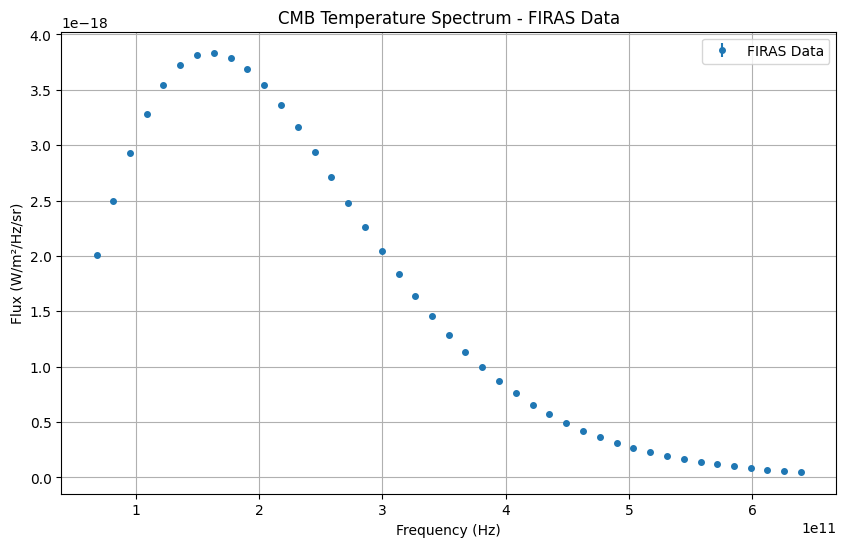

In [2]:
import numpy as np
import pandas as pd
import scipy.constants as const
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Load FIRAS data directly from text information.
firas_data_string = """
# COBE/FIRAS CMB monopole spectrum
# Reference1 = Table 4 of Fixsen et al. 1996 ApJ 473, 576.
# Reference2 = Fixsen & Mather 2002 ApJ 581, 817.
# Column 1 = frequency from Table 4 of Fixsen et al., units = cm^-1
# Column 2 = FIRAS monopole spectrum computed as the sum
#             of a 2.725 K BB spectrum and the
#             residual in column 3, units = MJy/sr
# Column 3 = residual monopole spectrum from Table 4 of Fixsen et al.,
#             units = kJy/sr
# Column 4 = spectrum uncertainty (1-sigma) from Table 4 of Fixsen et al.,
#             units = kJy/sr
# Column 5 = modeled Galaxy spectrum at the Galactic poles from Table 4 of
#             Fixsen et al., units = kJy/sr
#
#
# Revision History:
#  v1  : initial release, May 2005
#
  2.27   200.723      5     14      4
  2.72   249.508      9     19      3
  3.18   293.024     15     25     -1
  3.63   327.770      4     23     -1
  4.08   354.081     19     22      3
  4.54   372.079    -30     21      6
  4.99   381.493    -30     18      8
  5.45   383.478    -10     18      8
  5.90   378.901     32     16     10
  6.35   368.833      4     14     10
  6.81   354.063     -2     13     12
  7.26   336.278     13     12     20
  7.71   316.076    -22     11     25
  8.17   293.924      8     10     30
  8.62   271.432      8     11     36
  9.08   248.239    -21     12     41
  9.53   225.940      9     14     46
  9.98   204.327     12     16     57
 10.44   183.262     11     18     65
 10.89   163.830    -29     22     73
 11.34   145.750    -46     22     93
 11.80   128.835     58     23     98
 12.25   113.568      6     23    105
 12.71    99.451     -6     23    121
 13.16    87.036      6     22    135
 13.61    75.876    -17     21    147
 14.07    65.766      6     20    160
 14.52    57.008     26     19    178
 14.97    49.223    -12     19    199
 15.43    42.267    -19     19    221
 15.88    36.352      8     21    227
 16.34    31.062      7     23    250
 16.79    26.580     14     26    275
 17.24    22.644    -33     28    295
 17.70    19.255      6     30    312
 18.15    16.391     26     32    336
 18.61    13.811    -26     33    363
 19.06    11.716     -6     35    405
 19.51     9.921      8     41    421
 19.97     8.364     26     55    435
 20.42     7.087     57     88    477
 20.87     5.801   -116    155    519
 21.33     4.523   -432    282    573
"""

# Split the string into lines and filter out comment lines
lines = firas_data_string.strip().split('\n')
data_lines = [line for line in lines if not line.startswith("#") and line.strip()]

# Join the data lines back into a string
data_string = '\n'.join(data_lines)

# Load data into a DataFrame
from io import StringIO
data = pd.read_csv(StringIO(data_string), delim_whitespace=True, header=None)

# Assign proper column names
data.columns = ["Frequency_cm-1", "Flux_MJy_per_sr", "Residual_kJy_per_sr", "Uncertainty_kJy_per_sr", "Modeled_Galaxy_kJy_per_sr"]

# Convert flux uncertainty from kJy/sr to MJy/sr
data["Uncertainty_MJy_per_sr"] = data["Uncertainty_kJy_per_sr"] /1000.0

# Convert flux and residual from kJy/sr to MJy/sr
data["Flux_MJy_per_sr"] = data["Flux_MJy_per_sr"]
data["Residual_MJy_per_sr"] = data["Residual_kJy_per_sr"]/1000.0

#drop unnecessary columns
data.drop(columns=["Residual_kJy_per_sr", "Uncertainty_kJy_per_sr", "Modeled_Galaxy_kJy_per_sr"], inplace=True)

# Convert frequency from cm⁻¹ to Hz: f(Hz) = c * frequency(cm⁻¹)
data["Frequency_Hz"] = data["Frequency_cm-1"] * const.c * 100

# Convert flux and uncertainty from MJy/sr to SI units (W/m²/Hz/sr)
MJy_to_SI = 1e-20  # Conversion factor from MJy/sr to W/m²/Hz/sr
data["Flux_SI"] = data["Flux_MJy_per_sr"] * MJy_to_SI
data["Uncertainty_SI"] = data["Uncertainty_MJy_per_sr"] * MJy_to_SI

# Display the first few rows
data.head()

# Plot the data, with (invisible!) error bars
plt.figure(figsize=(10, 6))
plt.errorbar(data["Frequency_Hz"], data["Flux_SI"], yerr=data["Uncertainty_SI"], fmt='o', label="FIRAS Data", markersize=4)

# Labels and formatting
plt.xlabel("Frequency (Hz)")
plt.ylabel("Flux (W/m²/Hz/sr)")
plt.title("CMB Temperature Spectrum - FIRAS Data")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

Let's see how well we can do using a polynomial to fit the spectrum. This is of the form a + b f + c f$^2$ + d $f^3$ +...

The order of the polynomial is the highest exponent. A first order polynomial fit is linear, a + b f, a quadratic fit to a + bf + cf$^2$ is order 2, etc.

The cell below asks for a polynomial order, makes a least squares fit, and plots the residuals. Start with order = 2 and then increase it. What order gives a reasonable fit to the data? How do you assess that?

Note the cell prints out the reduced chi-squared for each fit.

You'll have to run the cell each time to pick a new polynomial order.

Make note of the reduced $\chi^2$ values for each polynomial order you choose.

Enter polynomial order (0–15): 8

Polynomial (in ν_GHz):
p(ν_GHz) = 0
R^2 = 0.999985
χ²/dof = 25.205 (dof = 34)


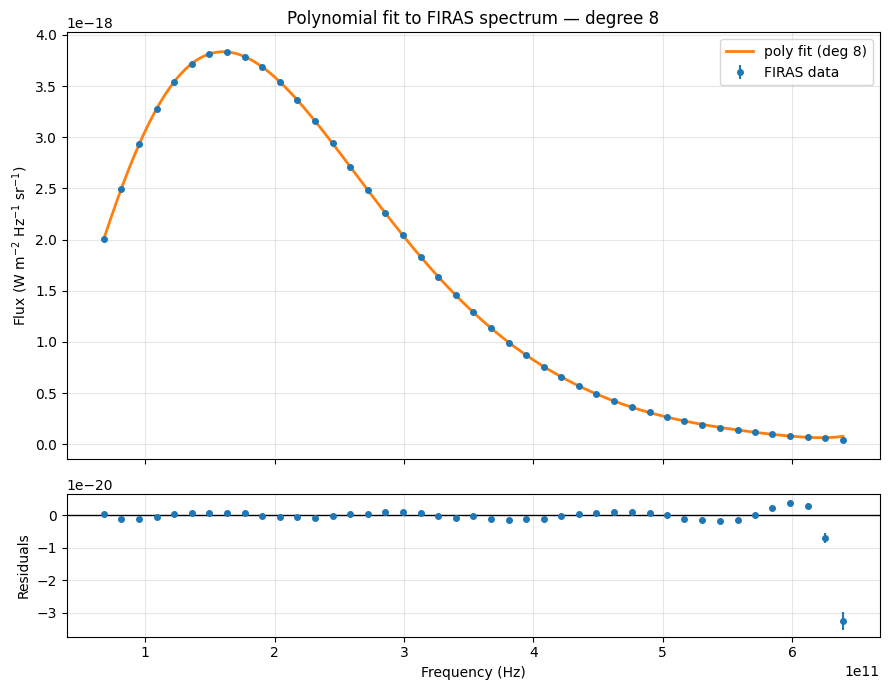

In [16]:
# === Polynomial fit to FIRAS spectrum with interrogation + residuals plot ===
import numpy as np
import matplotlib.pyplot as plt

# --- Pull data from your DataFrame ---
nu_hz = np.asarray(data["Frequency_Hz"], dtype=float)
y     = np.asarray(data["Flux_SI"], dtype=float)
yerr  = np.asarray(data["Uncertainty_SI"], dtype=float) if "Uncertainty_SI" in data else None

# --- Clean / basic checks ---
mask = np.isfinite(nu_hz) & np.isfinite(y)
if yerr is not None:
    mask &= np.isfinite(yerr) & (yerr > 0)
nu_hz, y = nu_hz[mask], y[mask]
yerr = yerr[mask] if yerr is not None else None
npts = nu_hz.size
if npts < 3:
    raise ValueError("Not enough valid points to fit.")

# --- Ask for polynomial degree ---
max_deg_allowed = max(0, min(15, npts - 2))  # keep sane; need >= deg+1 points
while True:
    try:
        deg = int(input(f"Enter polynomial order (0–{max_deg_allowed}): ").strip())
        if 0 <= deg <= max_deg_allowed:
            break
        print(f"Please enter an integer between 0 and {max_deg_allowed}.")
    except Exception:
        print("Couldn't parse that. Try an integer like 2 or 3.")

# --- Scale frequency for numerical conditioning (GHz) ---
nu_GHz = nu_hz / 1e9

# --- Weighted polyfit if yerr provided ---
w = None if yerr is None else 1.0 / yerr
coeffs = np.polyfit(nu_GHz, y, deg=deg, w=w)
p = np.poly1d(coeffs)

# --- Predictions on data and fine grid ---
y_fit = p(nu_GHz)
nu_fine = np.linspace(nu_GHz.min(), nu_GHz.max(), 800)
y_fine = p(nu_fine)

# --- Metrics: R^2 and reduced chi^2 (if yerr) ---
ss_res = np.sum((y - y_fit)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

dof = max(1, npts - (deg + 1))
if yerr is not None:
    chi2 = np.sum(((y - y_fit) / yerr)**2)
    red_chi2 = chi2 / dof
else:
    red_chi2 = np.nan

# --- Pretty-print polynomial in ν_GHz ---
def poly_to_string(c):
    terms = []
    n = len(c) - 1
    for i, a in enumerate(c):
        pwr = n - i
        if abs(a) < 1e-14:
            continue
        coef = f"{a:.6g}"
        if pwr == 0:
            terms.append(f"{coef}")
        elif pwr == 1:
            terms.append(f"{coef}·ν_GHz")
        else:
            terms.append(f"{coef}·ν_GHz^{pwr}")
    return " + ".join(terms) if terms else "0"

print("\nPolynomial (in ν_GHz):")
print(f"p(ν_GHz) = {poly_to_string(coeffs)}")
print(f"R^2 = {r2:.6f}")
if np.isfinite(red_chi2):
    print(f"χ²/dof = {red_chi2:.3f} (dof = {dof})")

# --- Plot: data + fit (top), residuals (bottom) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True,
                               gridspec_kw={"height_ratios": [3, 1]})

# Top: data and fit
if yerr is not None:
    ax1.errorbar(nu_hz, y, yerr=yerr, fmt='o', markersize=4, label="FIRAS data")
else:
    ax1.plot(nu_hz, y, 'o', markersize=4, label="FIRAS data")
ax1.plot(nu_fine*1e9, y_fine, lw=2, label=f"poly fit (deg {deg})")
ax1.set_ylabel("Flux (W m$^{-2}$ Hz$^{-1}$ sr$^{-1}$)")
ax1.set_title(f"Polynomial fit to FIRAS spectrum — degree {deg}")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Bottom: residuals
resid = y - y_fit
ax2.axhline(0, lw=1, color='k')
if yerr is not None:
    ax2.errorbar(nu_hz, resid, yerr=yerr, fmt='o', markersize=4)
else:
    ax2.plot(nu_hz, resid, 'o', markersize=4)
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Residuals")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Perform a Fit of a Physically Motivated Model to the CMB spectral data.
The shape of the blackbody spectrum is determined by a combination of thermal physics and quantum mechanics. Despite its complex shape, it is determined by one single parameter, Temperature, in conjunction with three fundamental physical constants: the Planck constant $h$, the Boltzmann constant $k$, and the speed of light $c$.

$$
B_{\nu}(\nu, T) = \frac{2h\nu^3}{c^2} \frac{1}{e^{\frac{h\nu}{kT}} - 1}.
$$

Here $B(\nu)$ is the spectral intensity, in units of Watts/Hz/steradian/m$^2$. If we had a sphere of surface area 1 m$^2$ emitting into 4$\pi$ of solid angle (the entire surrounding sphere) at a frequency $\nu$ we'd get $B_{\nu}/4\pi$ Watts in a measurement bandwidth of 1 Hz.

We have FIRAS measurements of $B_{\nu}(\nu)$ and so we can use those data to determine the CMB temperature $T$ that best matches the observations!

We can also see how well the data match the blackbody curve, by plotting the difference between the model and the data.

The fitting process basically starts with a guess for T, evaluates the model for that value of the parameter, computes at each observed frequency the difference between the model and the data, and adjusts $T$ to minimize the sum of those differences squared. This is why it's called a '*least squared fit'*.

The cell below defines a function that is evaluated for each observed $\nu$ for each trial value of T.

The cell then invokes the curve_fit() function to determine the best-fit value of $T$ and to assign an associated statistical uncertainty $\sigma_T$.

The FIRAS instrument flew on a satellite, and used a cryogenic blackbody source as a calibrator. The systematic uncertainty in the reported CMB spectrum arises from imperfect knowledge of the temperature and emissivity of that calibrator. This systematic uncertainty totally dominates the overall measurement uncertainty, and that is reflected in the code below.

 
Best-fit CMB Temperature: T=2.7250 ± 0.000007852 (statistical) ± 0.0010 (systematic) K
 


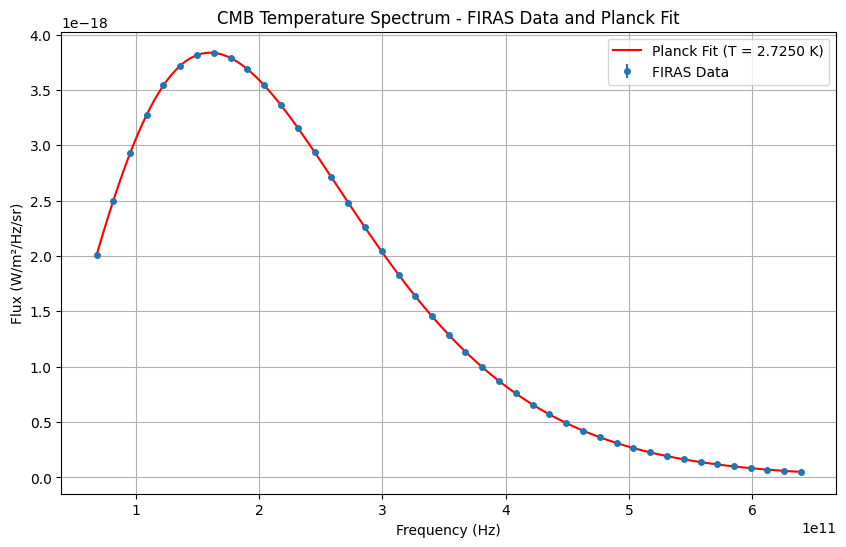

Reduced chi-squared: χ²/dof = 1.074 (dof = 42)


In [14]:

# Define the Planck blackbody function
def planck_law(frequency, temperature):
    """ Planck function for blackbody radiation. """
    return (2 * const.h * frequency**3 / const.c**2) / (np.exp((const.h * frequency) / (const.k * temperature)) - 1)

# Fit the Planck function to the data
def fit_blackbody(temp_guess=4.73):
    popt, pcov = opt.curve_fit(planck_law, data["Frequency_Hz"], data["Flux_SI"], sigma=data["Uncertainty_SI"], p0=[temp_guess])
    temp_fit = popt[0]  # Best-fit temperature
    temp_err = np.sqrt(np.diag(pcov))[0]  # Statistical uncertainty in temperature
    return temp_fit, temp_err

# Perform the fit
best_fit_temp, temp_stat_uncertainty = fit_blackbody()

# Include systematic uncertainty (~0.001 K from FIRAS calibration)
systematic_uncertainty = 0.001
total_uncertainty = np.sqrt(temp_stat_uncertainty**2 + systematic_uncertainty**2)

# Print results.
print(" ")
print(f"Best-fit CMB Temperature: T={best_fit_temp:.4f} ± {temp_stat_uncertainty:.9f} (statistical) ± {systematic_uncertainty:.4f} (systematic) K")
print(" ")

# Generate fitted Planck curve
freq_range = np.linspace(data["Frequency_Hz"].min(), data["Frequency_Hz"].max(), 500)
fitted_flux = planck_law(freq_range, best_fit_temp)

# Plot the data and best-fit Planck curve
plt.figure(figsize=(10, 6))
plt.errorbar(data["Frequency_Hz"], data["Flux_SI"], yerr=data["Uncertainty_SI"], fmt='o', label="FIRAS Data", markersize=4)
plt.plot(freq_range, fitted_flux, 'r-', label=f"Planck Fit (T = {best_fit_temp:.4f} K)")

# Labels and formatting
plt.xlabel("Frequency (Hz)")
plt.ylabel("Flux (W/m²/Hz/sr)")
plt.title("CMB Temperature Spectrum - FIRAS Data and Planck Fit")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# --- Calculate reduced chi-squared ---
residuals = data["Flux_SI"] - planck_law(data["Frequency_Hz"], best_fit_temp)
chi2 = np.sum((residuals / data["Uncertainty_SI"])**2)
dof = len(data["Flux_SI"]) - 1   # one fit parameter: temperature
red_chi2 = chi2 / dof

print(f"Reduced chi-squared: χ²/dof = {red_chi2:.3f} (dof = {dof})")


##Interpretation
We have evidence of a nearly perfect blackbody spectrum of photons at a temperature T=2.725 K, rattling around in the Universe. This is consistent with the idea that the expanding Universe started in a smaller, hotter, state and has been cooling off ever since.

The apparent temperature of the CMB sky is not *precisely* the same in all directions, however.
The Milky Way is moving relative to the CMB's rest frame, and the Earth is moving within the Milky Way. This introduces a dipole Doppler structure at the few milli-K level. In addition, there are subtle spatial corrugations at the $\mu$K level that are, we think, the imprint of quantum density fluctuations from the earliest moments of cosmic history.